## **Lunar Lander Training - DDQN**

### Imports and Setups

In [1]:
import os
import random
import gymnasium as gym
import time
import numpy as np
import matplotlib.pyplot as plt
from collections import namedtuple, deque
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from itertools import count

print(gym.__version__)
print(torch.__version__)

1.1.1
2.6.0


### GPU Check

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


### Hyperparameters

In [3]:
# Hyperparameters (TUNED FOR DDQN STABILITY & LONG-TERM PERFORMANCE)

MAX_EPISODES = 1000             # Increased to give DDQN time to converge
MEMORY_SIZE = 100_000           # Larger replay buffer for more diverse experience sampling
ROLLING_WINDOW = 20             # Okay — used for smoothing rewards
MAX_STEPS = 1000                # Okay

gamma = 0.99                    # Okay
epsilon = 1.0                   # Okay - Start with full exploration
epsilon_min = 0.01              # Okay - Standard minimum
epsilon_decay = 0.997           # Decrease - Slower decay to allow more exploration in early learning
learning_rate = 5e-4            # Increase - Slightly higher to speed up convergence, but still stable
batch_size = 64                 # Descrease - Reduce for more stochastic updates (better for learning early)
solved_threshold = 200          # Okay — default LunarLander solved benchmark
TAU = 0.005                     # Okay - Soft update — keep if you're using soft updates

### Environment Setup

In [4]:
env = gym.make("LunarLander-v3")
state_size = env.observation_space.shape[0]
action_size = env.action_space.n

### Building Training Model

In [5]:
#Model Definition
class DQN(nn.Module):
    def __init__(self, n_observations, n_actions):
        super().__init__()
        self.layer1 = nn.Linear(n_observations, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, n_actions)

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)

#Initialize Networks & Optimizer
policy_net = DQN(state_size, action_size).to(device)
target_net = DQN(state_size, action_size).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = optim.AdamW(policy_net.parameters(), lr=learning_rate)
criterion = nn.SmoothL1Loss()

### Replay Buffer & Functions

In [6]:
Transition = namedtuple("Transition", ["state", "action", "next_state", "reward", "done"])

class ReplayMemory:
    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)
    def push(self, *args):
        self.memory.append(Transition(*args))
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    def __len__(self):
        return len(self.memory)

replay_buffer = ReplayMemory(MEMORY_SIZE)

def select_action(state):
    global epsilon
    if np.random.rand() < epsilon:
        return torch.tensor([[env.action_space.sample()]], dtype=torch.long, device=device)
    with torch.no_grad():
        return policy_net(state).max(1).indices.view(1, 1)

### Training Loop - DDQN

In [7]:
rewards_per_episode = []
rolling_avg_rewards = []

start_time = time.time()

for episode in range(MAX_EPISODES):
    state, _ = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    total_reward = 0

    for t in count():
        action = select_action(state)
        next_state, reward, terminated, truncated, _ = env.step(action.item())

        done = terminated or truncated
        reward_tensor = torch.tensor([reward], device=device)
        next_state_tensor = torch.tensor(next_state, dtype=torch.float32, device=device).unsqueeze(0)

        replay_buffer.push(state, action, next_state_tensor, reward_tensor, done)
        state = next_state_tensor
        total_reward += reward

        if len(replay_buffer) >= batch_size:
            transitions = replay_buffer.sample(batch_size)
            states, actions, next_states, rewards, dones = zip(*transitions)

            states_batch = torch.cat(states)
            next_states_batch = torch.cat(next_states)
            actions_batch = torch.cat(actions)
            rewards_batch = torch.cat(rewards)
            dones_batch = torch.tensor(dones, device=device)

            # --- DDQN logic ---
            best_actions = policy_net(next_states_batch).argmax(1, keepdim=True)
            q_values = target_net(next_states_batch).gather(1, best_actions).squeeze()

            q_target = rewards_batch + gamma * q_values * ~dones_batch
            q_policy = policy_net(states_batch).gather(1, actions_batch)

            loss = criterion(q_policy, q_target.unsqueeze(1))
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
            optimizer.step()

            # Soft update of target network
            for target_param, main_param in zip(target_net.parameters(), policy_net.parameters()):
                target_param.data.copy_(TAU * main_param.data + (1.0 - TAU) * target_param.data)

        if done or t >= MAX_STEPS:
            rewards_per_episode.append(total_reward)
            rolling_avg = np.mean(rewards_per_episode[-ROLLING_WINDOW:])
            rolling_avg_rewards.append(rolling_avg)

            print(f"Episode {episode+1}/{MAX_EPISODES}, Reward: {total_reward:.2f}, Epsilon: {epsilon:.2f}, Rolling Avg: {rolling_avg:.2f}, Steps: {t}")
            break

    epsilon = max(epsilon_min, epsilon * epsilon_decay)

    if rolling_avg >= solved_threshold:
        print(f"Environment solved in {episode+1} episodes!")
        break

end_time = time.time()
print(f"Training completed in {(end_time - start_time)/60:.2f} minutes")

Episode 1/1000, Reward: -88.49, Epsilon: 1.00, Rolling Avg: -88.49, Steps: 77
Episode 2/1000, Reward: -120.32, Epsilon: 1.00, Rolling Avg: -104.41, Steps: 85
Episode 3/1000, Reward: -14.71, Epsilon: 0.99, Rolling Avg: -74.51, Steps: 112
Episode 4/1000, Reward: -111.20, Epsilon: 0.99, Rolling Avg: -83.68, Steps: 105
Episode 5/1000, Reward: 20.23, Epsilon: 0.99, Rolling Avg: -62.90, Steps: 86
Episode 6/1000, Reward: -119.10, Epsilon: 0.99, Rolling Avg: -72.27, Steps: 81
Episode 7/1000, Reward: -226.19, Epsilon: 0.98, Rolling Avg: -94.26, Steps: 111
Episode 8/1000, Reward: -116.05, Epsilon: 0.98, Rolling Avg: -96.98, Steps: 70
Episode 9/1000, Reward: -95.16, Epsilon: 0.98, Rolling Avg: -96.78, Steps: 69
Episode 10/1000, Reward: -190.87, Epsilon: 0.97, Rolling Avg: -106.19, Steps: 113
Episode 11/1000, Reward: -258.97, Epsilon: 0.97, Rolling Avg: -120.08, Steps: 115
Episode 12/1000, Reward: -81.22, Epsilon: 0.97, Rolling Avg: -116.84, Steps: 109
Episode 13/1000, Reward: -331.85, Epsilon: 0.

### Plot Rewards

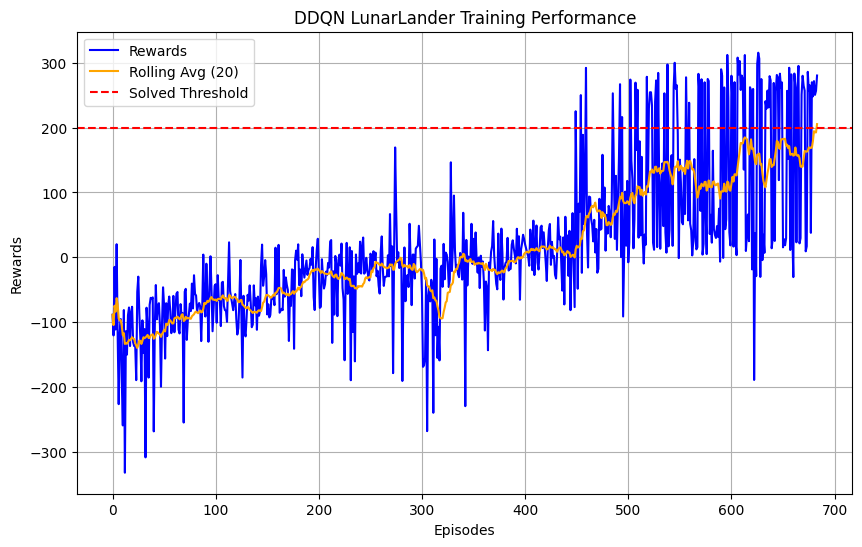

In [8]:
plt.figure(figsize=(10, 6))
plt.plot(rewards_per_episode, label='Rewards', color='blue')
plt.plot(rolling_avg_rewards, label=f'Rolling Avg ({ROLLING_WINDOW})', color='orange')
plt.axhline(y=solved_threshold, color='red', linestyle='--', label='Solved Threshold')
plt.title('DDQN LunarLander Training Performance')
plt.xlabel('Episodes')
plt.ylabel('Rewards')
plt.legend()
plt.grid()
plt.show()

### Save Model

In [9]:
model_path = os.path.join("..", "models", "ddqn_lunarlander_v2.pth")
torch.save(policy_net.state_dict(), model_path)
print(f"Model saved successfully at {model_path}!")

Model saved successfully at ../models/ddqn_lunarlander_v2.pth!
